In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from keras import callbacks

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "mfcc_data_more.json"

def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfccs"])
    y = np.array(data["labels"])
    genres = data["genres"]

    print("Data succesfully loaded!")

    return  X, y, genres

In [2]:
# load data
X, y, genres = load_data(DATA_PATH)

Data succesfully loaded!


In [21]:
# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [36]:
# build network topology
model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu'),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu'),

    # 3rd dense layer
    keras.layers.Dense(128, activation='relu'),
    
    # 4th dense layer
    keras.layers.Dense(64, activation='relu'),

    # output layer
    keras.layers.Dense(len(genres), activation='softmax')
])

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 8620)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               4413952   
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
Total params: 4,586,952
Trainable params: 4,586,952
No

In [37]:
# train model
earlystopping = callbacks.EarlyStopping(monitor ="val_accuracy", 
                                        mode ="max", patience = 8, 
                                        restore_best_weights = True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=30,callbacks=[earlystopping])

Epoch 1/30
35/35 [==============================] - 7s 109ms/step - loss: 9.4198 - accuracy: 0.3673 - val_loss: 5.3159 - val_accuracy: 0.4396
Epoch 2/30
35/35 [==============================] - 3s 100ms/step - loss: 4.3336 - accuracy: 0.5179 - val_loss: 3.6856 - val_accuracy: 0.4762
Epoch 3/30
35/35 [==============================] - 3s 94ms/step - loss: 1.9102 - accuracy: 0.6419 - val_loss: 3.6908 - val_accuracy: 0.5165
Epoch 4/30
35/35 [==============================] - 3s 83ms/step - loss: 2.3418 - accuracy: 0.6465 - val_loss: 3.7923 - val_accuracy: 0.4542
Epoch 5/30
35/35 [==============================] - 2s 69ms/step - loss: 0.9738 - accuracy: 0.7723 - val_loss: 3.0301 - val_accuracy: 0.5311
Epoch 6/30
35/35 [==============================] - 3s 78ms/step - loss: 0.8800 - accuracy: 0.7815 - val_loss: 3.2767 - val_accuracy: 0.5421
Epoch 7/30
35/35 [==============================] - 3s 73ms/step - loss: 1.5757 - accuracy: 0.6997 - val_loss: 3.2113 - val_accuracy: 0.5458
Epoch 8/30


Evaluate on test data
5/5 [==============================] - 0s 10ms/step - loss: 2.6727 - accuracy: 0.6484
test loss, test acc: [2.6726911067962646, 0.6483516693115234]


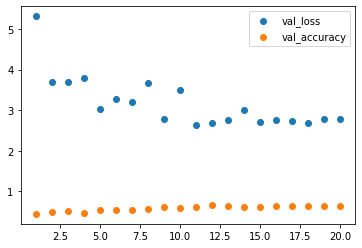

In [45]:
plt.scatter([i+1 for i in range(len(history.history['val_loss']))],history.history['val_loss'])
plt.scatter([i+1 for i in range(len(history.history['val_accuracy']))],history.history['val_accuracy'])
plt.legend(['val_loss','val_accuracy'])
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

In [39]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for tests")
predictions = model.predict(X_test)

Generate predictions for tests
9/9 [==============================] - 0s 18ms/step


In [46]:
correct = [0 for genre in genres]
pred_data = [[0 for g in genres] for genre in genres]
pred_count = [[0 for g in genres] for genre in genres]
genre_count = [0 for genre in genres]
for i in range(predictions.shape[0]):
    max_confidence = max(predictions[i])
    pred = np.argmax(predictions[i])
    actual = y_test[i]
    
    genre_count[actual] += 1
    pred_count[actual][pred] += 1
    pred_data[actual] += predictions[i]
    
    if pred == actual:
        correct[actual] += 1
    print('Prediction:', genres[pred], '\tActual:', genres[actual], '\nConfidence:', (predictions[i]),'\n')

pred_data = np.asarray(pred_data) / genre_count

Prediction: reggae 	Actual: reggae 
Confidence: [4.7797333e-02 1.6517648e-10 1.7247458e-01 7.8993686e-08 2.1588561e-07
 1.2445717e-07 1.7846197e-08 7.7972764e-01] 

Prediction: metal 	Actual: blues 
Confidence: [3.9232676e-03 9.6595102e-20 8.1734066e-07 2.4205598e-25 9.9607593e-01
 1.5957118e-09 8.1858554e-13 7.2629219e-10] 

Prediction: classical 	Actual: classical 
Confidence: [7.9554106e-11 9.9999571e-01 3.0788597e-18 4.2835450e-06 1.0938609e-15
 1.7554752e-23 8.8404373e-22 5.5929310e-23] 

Prediction: classical 	Actual: classical 
Confidence: [4.8945683e-17 1.0000000e+00 6.9474880e-17 1.2345739e-11 9.9145761e-12
 3.7077247e-35 1.4010337e-25 2.5186385e-28] 

Prediction: classical 	Actual: classical 
Confidence: [4.1795772e-07 9.9926192e-01 8.7863811e-10 7.3591800e-04 1.7055496e-06
 4.7013389e-19 1.8016035e-17 4.6934051e-10] 

Prediction: phonk 	Actual: phonk 
Confidence: [3.6800127e-10 2.6364647e-18 3.4953936e-07 5.0785359e-11 9.5308774e-09
 9.9968338e-01 3.1631408e-04 1.7460689e-12

In [47]:
curr_genre = 0
for c,g in zip(correct,genre_count):
    print(genres[curr_genre], ': ', c / g * 100,'% correct')
    curr_genre += 1

print('\nTotal: ', sum(correct) / sum(genre_count) * 100, '% correct')

blues :  44.0 % correct
classical :  92.6829268292683 % correct
disco :  68.57142857142857 % correct
jazz :  52.38095238095239 % correct
metal :  82.85714285714286 % correct
phonk :  50.0 % correct
pop :  53.65853658536586 % correct
reggae :  59.183673469387756 % correct

Total:  64.83516483516483 % correct


In [48]:
# Bar graphs for genre-specific confidence levels
# counter = 0
# for dist in pred_data:
#     plt.figure(counter, figsize=(8, 6))
#     plt.bar(x=genres, height=dist, color='#0504aa', alpha=0.7, width=0.8)
#     plt.grid(axis='y', alpha=0.75)
#     plt.xlabel('Genres')
#     plt.ylabel('Confidence')
#     plt.title(genres[counter])
#     counter += 1

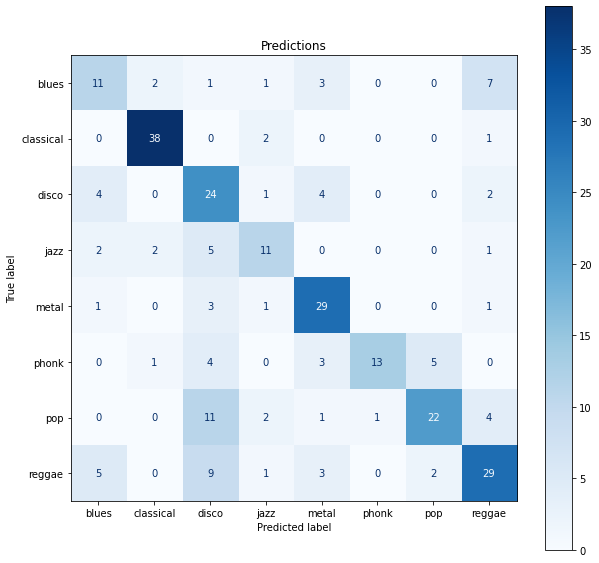

In [49]:
# Confusion matrix
confusion_matrix = np.asarray(pred_count)
# print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = genres)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax = ax, cmap='Blues')
plt.title("Predictions")
plt.show()

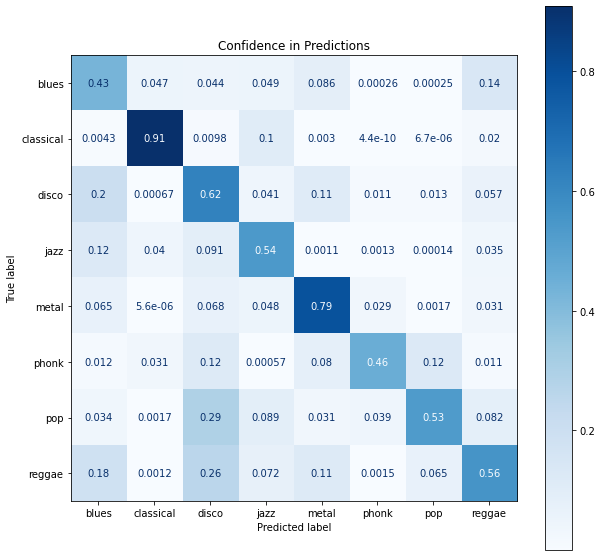

In [50]:
# Confusion matrix
confusion_matrix = np.asarray(pred_data)
# print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = genres)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax = ax, cmap='Blues')
plt.title("Confidence in Predictions")
plt.show()